# logistic Regression

In [1]:
import numpy as np
import pandas as pd

In [2]:
np.random.seed(42)

In [3]:
# Sigmoid fn
def sigmoid(z):
    z = np.array(z, dtype=np.float64)  
    z = np.clip(z, -500, 500)          # prevent overflow
    return 1 / (1 + np.exp(-z))

In [4]:
# Softmax fn
def softmax(z):
    z = np.array(z, dtype=np.float64)  
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [5]:
# logistic regression...
class logisticRegression:
    def __init__(self, lr=0.01, steps=1000):
        self.lr = lr
        self.steps = steps
        self.biases = None
        self.weights = None
        self.num_classes = None

    def fit(self, x, y):
        x = np.array(x, dtype=np.float64)
        y = np.array(y, dtype=np.int64)

        n_samples, n_features = x.shape
        self.num_classes = len(np.unique(y))
        self.weights = np.zeros((self.num_classes, n_features), dtype=np.float64)
        self.biases = np.zeros(self.num_classes, dtype=np.float64)

        # One-vs-Rest logistic regression
        for k in range(self.num_classes):
            y_binary = (y == k).astype(np.float64)
            w_k = np.zeros(n_features, dtype=np.float64)
            b_k = 0.0

            for _ in range(self.steps):
                z = (x @ w_k) + b_k
                y_pred = sigmoid(z)
                residual = y_pred - y_binary

                # Gradients
                dw = (1 / n_samples) * (x.T @ residual)
                db = (1 / n_samples) * np.sum(residual)

                # Update weights & bias
                w_k -= self.lr * dw
                b_k -= self.lr * db

            self.weights[k] = w_k
            self.biases[k] = b_k

    def predict_probability(self, x):
        x = np.array(x, dtype=np.float64)
        z = (x @ self.weights.T) + self.biases
        return softmax(z)

    def predict(self, x):
        return np.argmax(self.predict_probability(x), axis=1)

In [6]:
df = pd.read_csv('../dataset/satellite_signal_dataset.csv')
df.head()

,orbit_type,distance_m,frequency_hz,transmit_power_dbw,transmit_antenna_diameter_m,receive_antenna_diameter_m,rain_rate_mmhr,atmospheric_loss_db,pointing_error_deg,bandwidth_hz,...,transmit_antenna_gain_db,receive_antenna_gain_db,fspl_db,rain_attenuation_db,pointing_loss_db,transmit_power_dbm,received_power_dbm,noise_power_dbm,cn_ratio_db,signal_quality
0,GEO,3.565755e+07,1.626957e+09,24.599966,1.097824,2.302199,8.523263,1.951948,0.057916,2.376473e+07,...,23.220260,29.652463,187.712322,0.046653,0.001281,54.599966,-82.239514,-101.064908,18.825394,Good
1,MEO,1.153046e+07,2.732246e+10,13.690240,0.689636,2.678975,0.784847,1.817429,0.000000,2.574373e+07,...,43.684873,55.471854,202.409099,2.781469,0.000000,43.690240,-64.161030,-100.093471,35.932441,Good
2,LEO,8.547917e+05,6.435908e+09,16.932794,0.752718,1.550586,14.636986,1.377592,0.080622,4.398066e+07,...,31.886933,38.164197,167.251175,0.163628,0.017614,46.932794,-51.826086,-101.616579,49.790493,Good
3,LEO,6.793379e+05,2.754270e+10,23.265613,0.861342,1.080783,9.264690,1.733032,1.207310,2.521968e+06,...,45.685729,47.656980,177.883618,1.511315,35.145513,53.265613,-69.665155,-110.930365,41.265211,Good
4,GEO,3.586736e+07,1.499221e+10,19.641787,0.907307,1.160886,12.557483,1.412742,0.000000,2.388476e+07,...,40.854477,42.995185,207.053070,45.040371,0.000000,49.641787,-120.014733,-103.200321,-16.814412,Poor


In [7]:
# Encode categorical column -> 'orbit_type'
df = pd.get_dummies(df, columns=['orbit_type'], prefix='orbit')

In [8]:
# defining features and target...
features = [col for col in df.columns if col != 'signal_quality']
x = df[features].values
y = df['signal_quality'].map({'Good': 2, 'Moderate': 1, 'Poor': 0}).values

In [9]:
# Standardizing features...
x_mean = np.mean(x, axis=0, dtype=np.float64)
x_std = np.std(x, axis=0, dtype=np.float64)
x_std[x_std == 0] = 1
x = (x - x_mean) / x_std

In [10]:
# train-test split
n_samples = x.shape[0]
indices = np.random.permutation(n_samples)
train_size = int(n_samples * 0.8)
train_idx, test_idx = indices[:train_size], indices[train_size:]
x_train, x_test = x[train_idx], x[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [11]:
# applying logistic regression...
model = logisticRegression(lr=0.01, steps=1000)
model.fit(x_train, y_train)

In [12]:
# prediction on test data...
y_pred = model.predict(x_test)
y_pred

array([2, 2, 2, ..., 2, 2, 2])

In [13]:
# accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9307


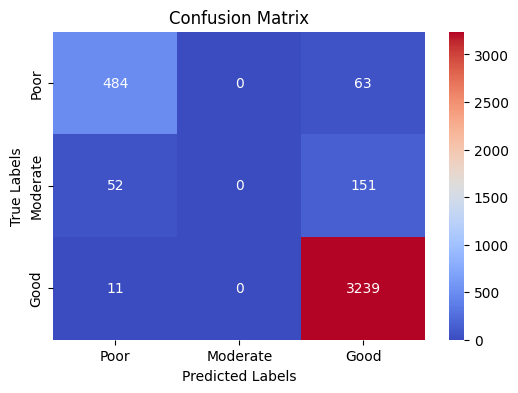

In [14]:
# confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = ['Poor', 'Moderate', 'Good']

# Compute confusion matrix
num_classes = len(class_labels)
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for true, pred in zip(y_test, y_pred):
    conf_matrix[true, pred] += 1

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [15]:
# Mapping from numeric to text labels 
label_map = {0: 'Poor', 1: 'Moderate', 2: 'Good'}

# Save predictions to CSV with readable labels
results = pd.DataFrame({
    'True_Label': [label_map[t] for t in y_test],
    'Predicted_Label': [label_map[p] for p in y_pred]
})

results.to_csv('../predictions/logistic_regression_predictions.csv', index=False)
print("\nPredictions saved to 'logistic_regression_predictions.csv'")


Predictions saved to 'logistic_regression_predictions.csv'
